<a href="https://colab.research.google.com/github/NaviaEddy/SIS421_LAB05/blob/main/Lab_05_NaviaCondoriEddy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/blog/blob/master/062_multihead_attention/multihead_attention.ipynb)

In [1]:
!pip install pytorch-lightning

## Implementación

In [2]:
import pytorch_lightning as pl
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.datasets import fetch_openml
import numpy as np
from torch.utils.data import DataLoader
from scipy.io import loadmat

from torchvision import datasets, transforms

import pandas as pd
from tensorflow import keras

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import zipfile
import os

# Ruta al archivo zip que deseas descomprimir
zip_file_path = '/content/drive/MyDrive/SIS421/LAB_5/Perros_dataset.zip'

# Directorio de destino donde se extraerán los archivos
extract_dir = '/content/zip_extraido'

# Crear el directorio de destino si no existe
os.makedirs(extract_dir, exist_ok=True)

# Descomprimir el archivo zip
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("¡Descompresión completada!")


¡Descompresión completada!


In [5]:
import os
import numpy as np
import random
from PIL import Image

def cargar_dataset_train(ruta_dataset, tamaño_imagen=(50, 50)):
    # Reiniciar variables
    dataset = []

    # Obtener clases del nuevo dataset y ordenarlas
    clases = sorted(os.listdir(ruta_dataset))

    # Mapeo de etiquetas a valores numéricos
    etiquetas_mapping = {clase: idx for idx, clase in enumerate(clases)}

    for clase in clases:
        #print(f"Procesando clase testing: {clase} ({etiquetas_mapping[clase]})")
        ruta_clase = os.path.join(ruta_dataset, clase)
        etiqueta_num = etiquetas_mapping[clase]  # Obtener el valor numérico de la etiqueta directamente
        with os.scandir(ruta_clase) as entries:
            for idx, entry in enumerate(entries, start=1):
                if entry.is_file():
                    imagen_ruta = os.path.join(ruta_clase, entry.name)
                    # Abrir imagen como objeto PIL
                    imagen = Image.open(imagen_ruta).convert('RGB')
                    # Redimensionar imagen
                    imagen_resized = imagen.resize(tamaño_imagen)
                    # Convertir imagen a array de NumPy
                    imagen_array = np.array(imagen_resized) / 255.0  # Normalizar la imagen
                    dataset.append((imagen_array, etiqueta_num))  # Tupla con imagen y etiqueta numérica

    random.shuffle(dataset)
    # Obtener X (imágenes) y y (etiquetas)
    X = np.array([item[0] for item in dataset])
    y = np.array([item[1] for item in dataset])

    return X, y

In [7]:
classes = ('Afghan hound', 'Beagle', 'Bulldog Ingles', 'Collie', 'Coocker', 'German Pointer', 'Golden retriever', 'Malamutes'
          , 'Pug', 'Saint bernard', 'Schnauzer', 'Siberian husky')

In [8]:
ruta_dataset = '/content/zip_extraido/Perros_dataset'
X, y = cargar_dataset_train(ruta_dataset, tamaño_imagen=(50, 50))
print("Dimensiones de X:", X.shape)
print("Dimensiones de y:", y.shape)

Dimensiones de X: (60484, 50, 50, 3)
Dimensiones de y: (60484,)


In [76]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    return torch.tensor(self.X[ix]).float(), torch.tensor(self.y[ix]).long()

class MNISTDataModule(pl.LightningDataModule):

    def __init__(self, batch_size: int = 64, Dataset = Dataset):
        super().__init__()
        self.batch_size = batch_size
        self.Dataset = Dataset

    def setup(self, stage=None):
        # mnist = fetch_openml('mnist_784', version=1)
        # X, y = mnist["data"], mnist["target"]
        #(X_train, y_train), (X_test, y_test) = '/content/datos_perros.npz'

        # Access arrays using keys
        X_train, y_train = X, y
        X_test, y_test = X, y
        X_train, X_test, y_train, y_test = X[:50000], X[50000:], y[:50000].astype(np.int64), y[50000:].astype(np.int64)
        X_train = X_train.reshape(-1, 7500)
        X_test = X_test.reshape(-1, 7500)
        self.train_ds = self.Dataset(X_train, y_train)
        self.val_ds = self.Dataset(X_test, y_test)

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size)

In [77]:
dm = MNISTDataModule()
dm.setup()
imgs, labels = next(iter(dm.train_dataloader()))
imgs.shape, labels.shape

(torch.Size([64, 7500]), torch.Size([64]))

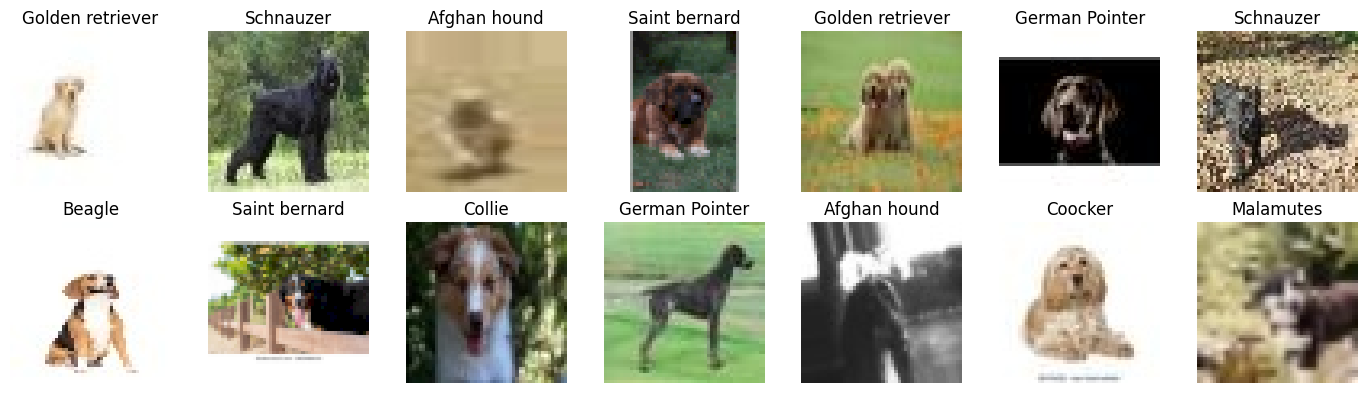

In [78]:
r, c = 2, 7
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        ix = _r*c + _c
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.axis("off")
        ax.imshow(img.reshape(50,50,3))
        ax.set_title(classes[label.item()])
plt.tight_layout()
plt.show()

In [79]:
class MLP(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(50*50*3, 7500),
            torch.nn.BatchNorm1d(7500),  # Batch Normalization después de la primera capa lineal
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(7500, 3000),
            torch.nn.BatchNorm1d(3000),  # Batch Normalization después de la segunda capa lineal
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(3000, 12)
        )

    def forward(self, x):
        return self.mlp(x)

    def predict(self, x):
        with torch.no_grad():
          y_hat = self(x)
          return torch.argmax(y_hat, axis=1)

    def compute_loss_and_acc(self, batch):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.shape[0]
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('loss', loss)
        self.log('acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.003)
        return optimizer

In [80]:
mlp = MLP()
outuput = mlp(torch.randn(64, 7500))
outuput.shape

torch.Size([64, 12])

In [81]:
mlp = MLP()
trainer = pl.Trainer(max_epochs=5, logger=None)
trainer.fit(mlp, dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type       | Params
------------------------------------
0 | mlp  | Sequential | 78.8 M
------------------------------------
78.8 M    Trainable params
0         Non-trainable params
78.8 M    Total params
315.270   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Obtenemos una precisión en los datos de validación del 97%, nada impresionante debido a la simplicidad del modelo.

<Figure size 640x480 with 0 Axes>

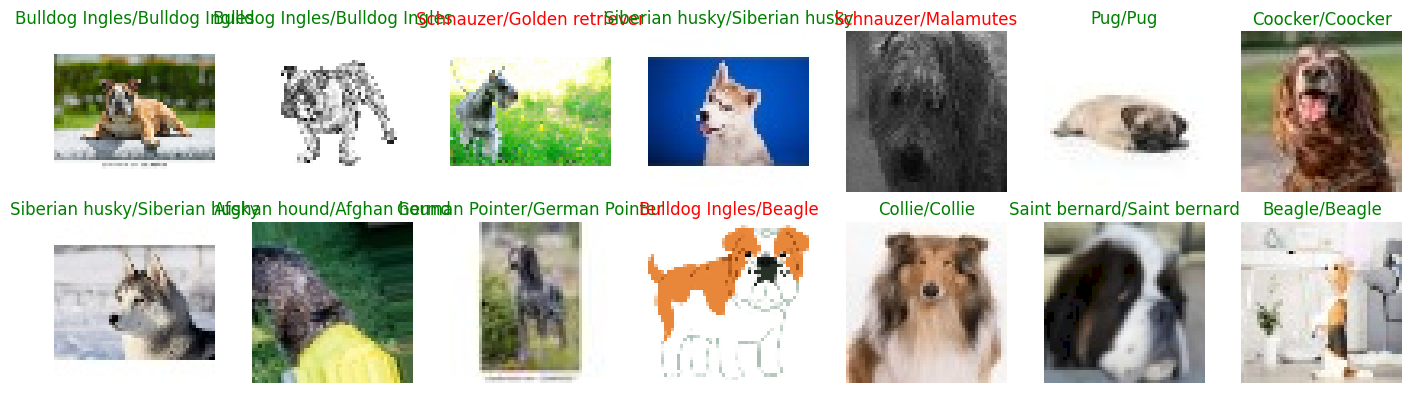

In [82]:
imgs, labels = next(iter(dm.val_dataloader()))
preds = mlp.predict(imgs)

r, c = 2, 7
plt.subplots_adjust(wspace=0.5, hspace=0.8)
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        ix = _r*c + _c
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.axis("off")
        ax.imshow(img.reshape(50,50,3))
        ax.set_title(f'{classes[label.item()]}/{classes[preds[ix].item()]}', color="green" if label == preds[ix] else 'red')
plt.tight_layout()
plt.show()

Vamos ahora a resolver el mismo problema, utilizando el mecanismo de atención descrito anteriormente. Lo primero que tenemos que tener en cuenta es que los mecanismos de atención funcionan con secuencias, por lo que tenemos que reinterpretar nuestras imágenes. Para ello, vamos a dividirlas en 16 *patches* de 7x7. De esta manera, nuestras imágenes ahora serán secuencias de *patches* con las que nuestro mecanismo de atención podrá trabajar.

In [89]:
class AttnDataset(torch.utils.data.Dataset):
  def __init__(self, X, y, patch_size=(10, 10)):
    self.X = X
    self.y = y
    self.patch_size = patch_size

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    image = torch.tensor(self.X[ix]).float().view(50, 50, 3) # 50 x 50
    h, w = self.patch_size
    patches = image.unfold(0, h, h).unfold(1, w, w).unfold(2, 3, 3) # 5 x 5 x 10 x 10 x 3
    patches = patches.contiguous().view(-1, h*w*3) # 25 x 300
    return patches, torch.tensor(self.y[ix]).long()

In [90]:
attn_dm = MNISTDataModule(Dataset = AttnDataset)
attn_dm.setup()
imgs, labels = next(iter(attn_dm.train_dataloader()))
imgs.shape, labels.shape

(torch.Size([64, 25, 300]), torch.Size([64]))

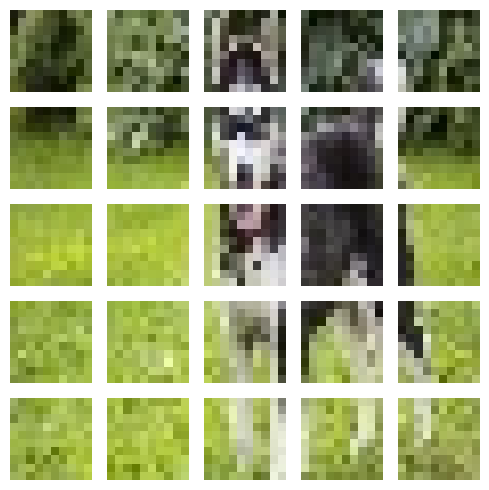

In [91]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(5,5))
for i in range(5):
    for j in range(5):
        ax = plt.subplot(5, 5, (i*5) + j + 1)
        ax.imshow(imgs[5,i*5 + j].view(10, 10, 3))
        ax.axis('off')
plt.tight_layout()
plt.show()

Debido a la baja dimensionalidad de nuestro ejemplo, vamos a repetir nuestro mecanismo de atención básico `n_heads` número de veces. Sin embargo, en la práctica, se divide la dimensión del `embedding` por este número de cabezas. Un detalle importante a tener en cuenta :)

In [111]:
# basado en: https://github.com/karpathy/minGPT/blob/master/mingpt/model.py
import math

class MultiHeadAttention(torch.nn.Module):

    def __init__(self, n_embd, n_heads):
        super().__init__()
        self.n_heads = n_heads

        # key, query, value projections
        self.key = torch.nn.Linear(n_embd, n_embd*n_heads)
        self.query = torch.nn.Linear(n_embd, n_embd*n_heads)
        self.value = torch.nn.Linear(n_embd, n_embd*n_heads)

        # output projection
        self.proj = torch.nn.Linear(n_embd*n_heads, n_embd)

    def forward(self, x):
        B, L, F = x.size()

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        q = self.query(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        v = self.value(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)

        # attention (B, nh, L, F) x (B, nh, F, L) -> (B, nh, L, L)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = torch.nn.functional.softmax(att, dim=-1)
        y = att @ v # (B, nh, L, L) x (B, nh, L, F) -> (B, nh, L, F)
        y = y.transpose(1, 2).contiguous().view(B, L, F*self.n_heads) # re-assemble all head outputs side by side

        return self.proj(y)

class Model(MLP):

    def __init__(self, n_embd=10*10*3, seq_len=5*5, n_heads=5*5):
        super().__init__()
        self.mlp = None

        self.attn = MultiHeadAttention(n_embd, n_heads)
        self.bn = torch.nn.BatchNorm1d(n_embd*seq_len)
        self.actn = torch.nn.ReLU(inplace=True)
        self.fc = torch.nn.Linear(n_embd*seq_len, 12)

    def forward(self, x):
        x = self.attn(x)
        x = x.view(x.size(0), -1)
        x = self.bn(x)  # Aplicar Batch Normalization
        x = x.view(x.size(0), -1, 1, 1)
        y = self.fc(self.actn(x.view(x.size(0), -1)))
        #print(y.shape)
        return y

In [112]:
model = Model()
trainer = pl.Trainer(max_epochs=5, logger=None)
trainer.fit(model, attn_dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type               | Params
--------------------------------------------
0 | attn | MultiHeadAttention | 9.0 M 
1 | bn   | BatchNorm1d        | 15.0 K
2 | actn | ReLU               | 0     
3 | fc   | Linear             | 90.0 K
--------------------------------------------
9.1 M     Trainable params
0         Non-trainable params
9.1 M     Total params
36.511    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Ahora nuestro modelo tiene mayor capacidad de representación (más parámetros) y, por lo tanto, obtenemos resultados mejores.

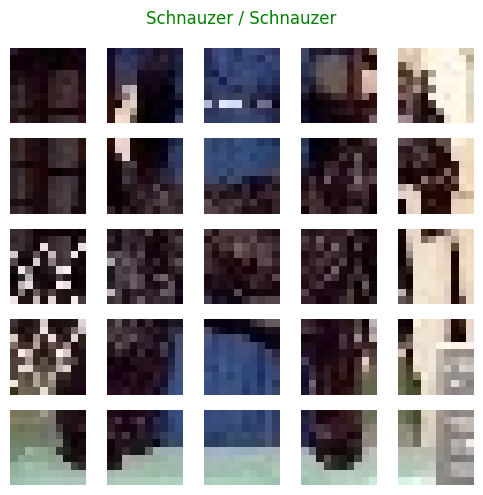

In [118]:
import random

attn_imgs, attn_labels = next(iter(attn_dm.val_dataloader()))
preds = model.predict(attn_imgs)

ix = random.randint(0,attn_dm.batch_size)
fig = plt.figure(figsize=(5,5))
for i in range(5):
    for j in range(5):
        ax = plt.subplot(5, 5, i*5 + j + 1)
        ax.imshow(attn_imgs[ix,i*5 + j].view(10, 10, 3))
        ax.axis('off')
fig.suptitle(f'{classes[attn_labels[ix]]} / {classes[preds[ix].item()]}', color="green" if attn_labels[ix] == preds[ix].item() else "red")
plt.tight_layout()
plt.show()